## Семинар 9: "LSTM"[SOLVED]

ФИО:Шпитальник Александр Сергеевич

In [2]:
import numpy as np
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
import pandas
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
%matplotlib inline

/home/alex/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

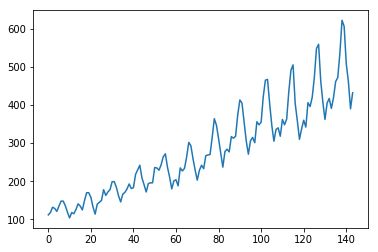

In [4]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [5]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


(96, 48)


In [7]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + 1:i + look_back + 1, 0])

    return np.array(dataX), np.array(dataY)

In [8]:
# Пример подготовленных данных

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
class RecNetwork(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size):
        super(RecNetwork, self).__init__()
        self.type = cell_type
        self.hidden_size = hidden_size
        if cell_type == 'torch':
            self.module = nn.LSTM(input_size, hidden_size)
        else:
            self.module = LSTM(input_size, hidden_size)
        self.dense = nn.Sequential((nn.Linear(self.hidden_size, 1)))
        
        
        
    def forward(self, inputs, hidden):
        inputs = inputs.permute(2, 0, 1)
        pred, hidden = self.module.forward(inputs, hidden)
        res = self.dense(pred)
        res = res.permute(1, 0, 2)[:, :, 0]
        return res, hidden 
        
        
        

In [10]:
class SimpleDS(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

In [11]:
class Network: 
    def __init__(self, cell_type, seq_size, hidden_size, batch_size):
        self.type = cell_type
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.seq_size = seq_size
        self.model = RecNetwork(cell_type, 1, hidden_size)
        
        
    def init_hidden(self):
        if self.type == 'torch':
            self.hidden = (torch.zeros(1, self.cur_batch_size, self.hidden_size), 
                           torch.zeros(1, self.cur_batch_size, self.hidden_size))
        else:     
            self.hidden = (torch.zeros(self.cur_batch_size, self.hidden_size), 
                           torch.zeros(self.cur_batch_size, self.hidden_size))
            
    
    def train(self, epochs, learning_rate):    
        loss = nn.MSELoss()
        train_loss_epochs = []
        test_loss_epochs = []
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        
        try:
            for epoch in range(epochs):
                losses = []
                for X, y in self.train_loader:
                    self.cur_batch_size = X.shape[0]
                    self.model.zero_grad()
                    self.init_hidden()
                    prediction, _ = self.model.forward(X, self.hidden)
                    loss_batch = loss(prediction, y)
                    losses.append(loss_batch.item())
                    loss_batch.backward(retain_graph=True)
                    optimizer.step()
                train_loss_epochs.append(np.mean(losses))
                losses = [] 
                
                for X, y in self.test_loader:
                    self.cur_batch_size = X.shape[0]
                    self.init_hidden()
                    prediction, _ = self.model.forward(X, self.hidden)
                    loss_batch = loss(prediction, y)
                    losses.append(loss_batch.item())
                test_loss_epochs.append(np.mean(losses))
                
                if epoch % 10 == 0:
                    clear_output(True)
                    print('\rEpoch {0}... (Train/Test) MSE: {1:.5f}/{2:.5f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
                    
                    plt.figure(figsize=(12, 5))
                    plt.subplot(1, 2, 1)
                    plt.plot(train_loss_epochs, label='Train')
                    plt.plot(test_loss_epochs, label='Test')
                    plt.xlabel('Epochs', fontsize=16)
                    plt.ylabel('Loss', fontsize=16)
                    plt.legend(loc=0, fontsize=16)
                    plt.grid()
                    
                    true, predicted = self.predict()        
                    plt.subplot(1, 2, 2)
                    plt.plot(true, label='True')
                    plt.plot(predicted, label='Prediction')
                    plt.legend()
                    plt.grid()
                    
                    plt.show()
                    
        except KeyboardInterrupt:
            pass
        return train_loss_epochs, \
               test_loss_epochs
        
        
    def predict(self):
        predicted = []
        vals = []
        for X, y in self.fin_test_loader:
            self.cur_batch_size = X.shape[0]
            self.init_hidden()
            prediction, _ = self.model.forward(X, self.hidden)
            for i in range(self.cur_batch_size):
                predicted.append(prediction[i,self.seq_size - 1])
                vals.append(y[i,self.seq_size - 1])         
        
        return vals, predicted
        
        
    def prepare(self, dataset):
        
        train_size = int(len(dataset) * 0.67)
        test_size = len(dataset) - train_size
        train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
        
        trainX, trainY = create_dataset(train, self.seq_size)
        testX, testY = create_dataset(test, self.seq_size)

        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
        
        dataset_train = SimpleDS(trainX, trainY)
        dataset_test = SimpleDS(testX, testY)
        
        self.fin_test_loader = DataLoader(dataset_test, shuffle=False, batch_size= len(dataset_test))
        self.fin_train_loader = DataLoader(dataset_train, shuffle=False, batch_size= len(dataset_train))

        self.train_loader = DataLoader(dataset_train, shuffle=True, batch_size= self.batch_size)
        self.test_loader = DataLoader(dataset_test, shuffle=True, batch_size= self.batch_size)
        
        
        
    def OnStart(self, dataset, epoch, learning_rate):
        self.prepare(dataset)
        self.train(epoch, learning_rate)
        self.predict()
        
    
        
        

Epoch 490... (Train/Test) MSE: 0.00155/0.01299


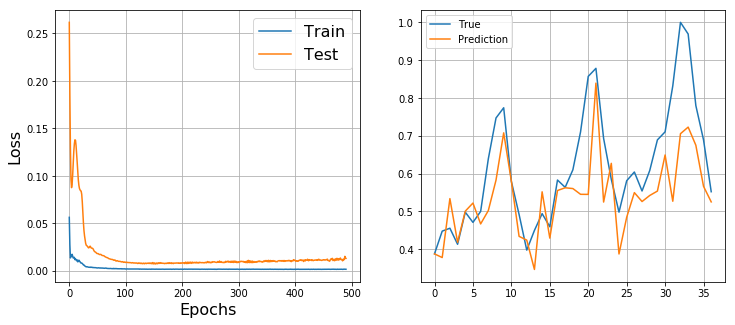

In [26]:
network = Network('torch', seq_size = 10, hidden_size = 10, batch_size = 64)
network.OnStart(dataset, 500, 0.01)

Epoch 490... (Train/Test) MSE: 0.00145/0.01475


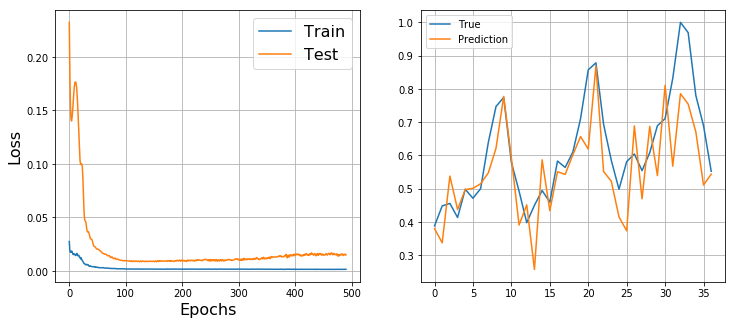

In [27]:
network = Network('torch', seq_size = 10, hidden_size = 5, batch_size = 64)
network.OnStart(dataset, 500, 0.01)

Epoch 490... (Train/Test) MSE: 0.00194/0.00906


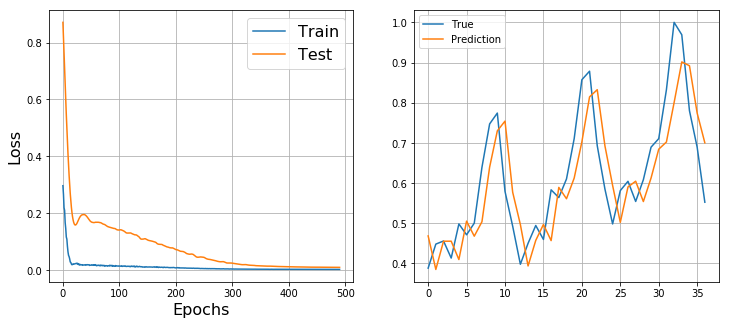

In [28]:
network = Network('torch', seq_size = 10, hidden_size = 1, batch_size = 64)
network.OnStart(dataset, 500, 0.01)

Epoch 490... (Train/Test) MSE: 0.00160/0.01130


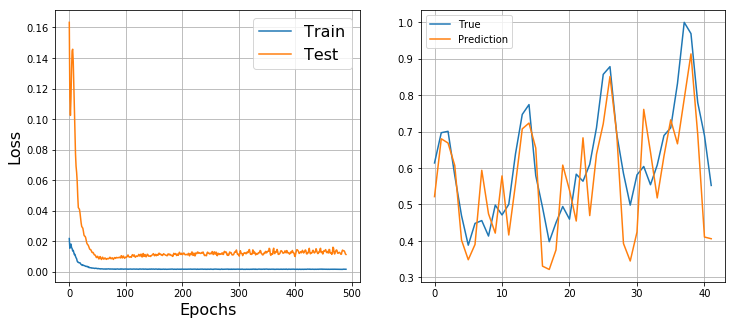

In [29]:
network = Network('torch', seq_size = 5, hidden_size = 10, batch_size = 64)
network.OnStart(dataset, 500, 0.01)

Epoch 490... (Train/Test) MSE: 0.00159/0.00913


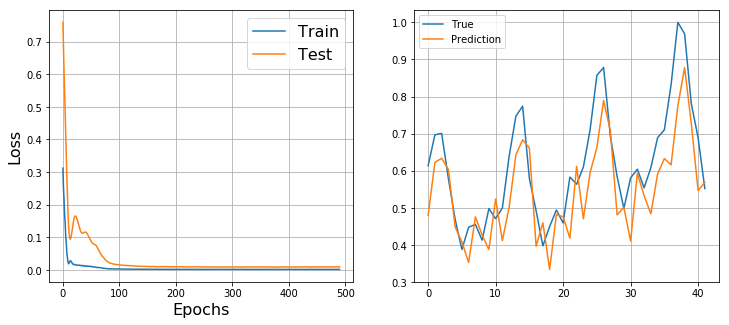

In [30]:
network = Network('torch', seq_size = 5, hidden_size = 5, batch_size = 64)
network.OnStart(dataset, 500, 0.01)

Epoch 490... (Train/Test) MSE: 0.00177/0.01059


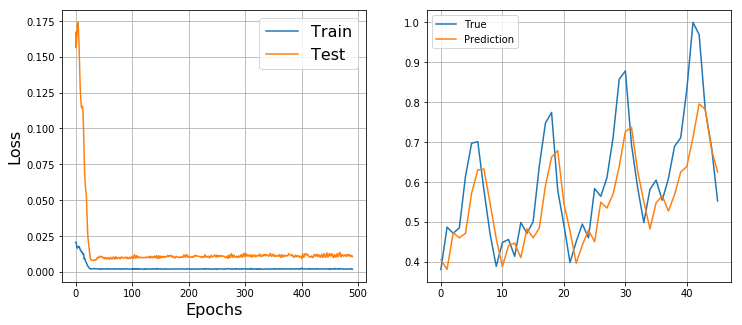

In [31]:
network = Network('torch', seq_size = 1, hidden_size = 10, batch_size = 64)
network.OnStart(dataset, 500, 0.01)

Epoch 490... (Train/Test) MSE: 0.00189/0.02312


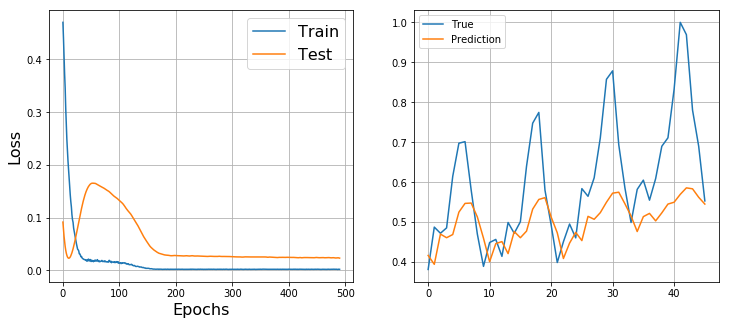

In [32]:
network = Network('torch', seq_size = 1, hidden_size = 1, batch_size = 64)
network.OnStart(dataset, 500, 0.01)

Epoch 490... (Train/Test) MSE: 0.00176/0.00791


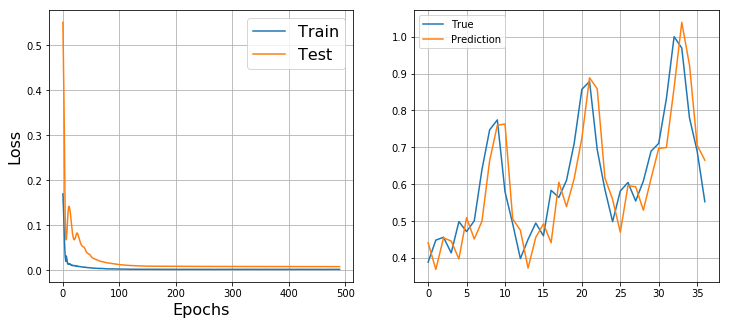

In [33]:
network = Network('my', seq_size = 10, hidden_size = 10, batch_size = 64)
network.OnStart(dataset, 500, 0.01)

Epoch 490... (Train/Test) MSE: 0.00198/0.00788


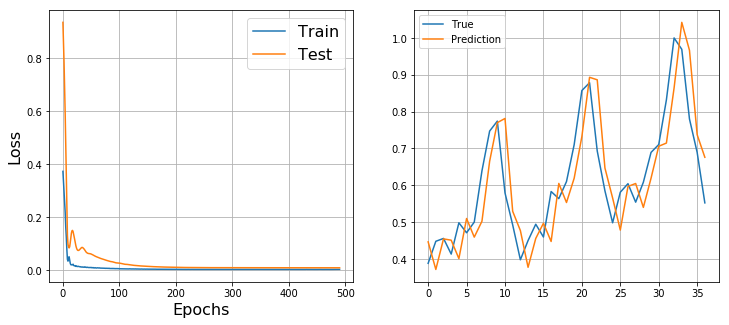

In [34]:
network = Network('my', seq_size = 10, hidden_size = 5, batch_size = 64)
network.OnStart(dataset, 500, 0.01)

Epoch 490... (Train/Test) MSE: 0.00184/0.01140


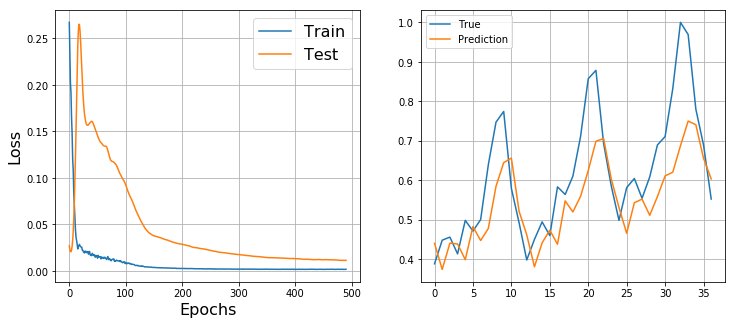

In [35]:
network = Network('my', seq_size = 10, hidden_size = 1, batch_size = 64)
network.OnStart(dataset, 500, 0.01)

Epoch 490... (Train/Test) MSE: 0.00180/0.00799


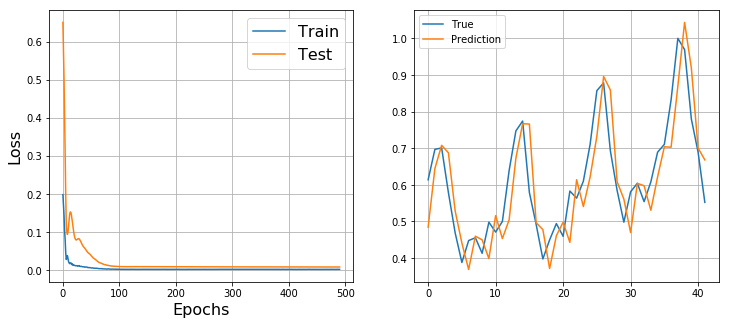

In [36]:
network = Network('my', seq_size = 5, hidden_size = 10, batch_size = 64)
network.OnStart(dataset, 500, 0.01)

Epoch 490... (Train/Test) MSE: 0.00173/0.00885


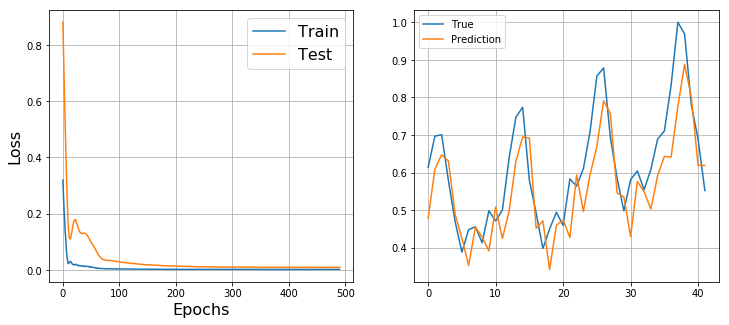

In [37]:
network = Network('torch', seq_size = 5, hidden_size = 5, batch_size = 64)
network.OnStart(dataset, 500, 0.01)

Epoch 490... (Train/Test) MSE: 0.00194/0.01007


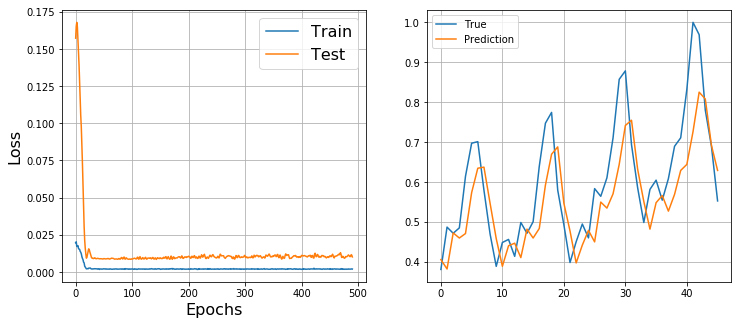

In [38]:
network = Network('my', seq_size = 1, hidden_size = 10, batch_size = 64)
network.OnStart(dataset, 500, 0.01)

Epoch 490... (Train/Test) MSE: 0.00205/0.01079


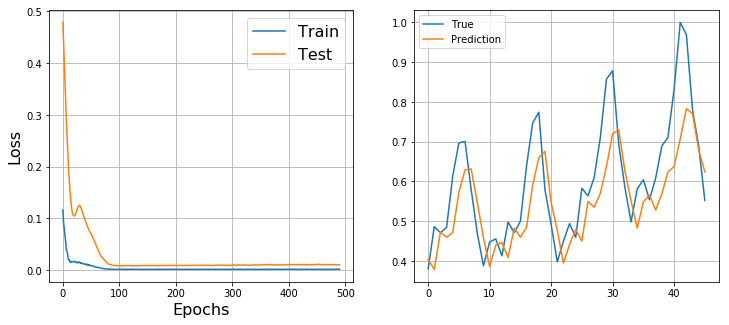

In [39]:
network = Network('my', seq_size = 1, hidden_size = 1, batch_size = 64)
network.OnStart(dataset, 500, 0.01)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: